## Image segmentation:

For this problem you will write code to segment an
image into regions using k-means clustering to group
pixels. You will experiment with two different feature
spaces---color and texture---and play with some design
choices to understand their impact. Include each of the
following, writing any additional functions as needed. 

In [2]:
import numpy as np
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from skimage import data, io, util, transform, filters, color
from skimage.color import rgb2gray
from skimage import feature
from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
from skimage.viewer import ImageViewer

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle

import os
plt.gray()
data_dir = "C:\\Users\\aramacha\\AnacondaProjects\\CS376\\AssignWriteups\\Assign2\\a2-provided-files"
print (data_dir)

C:\Anaconda\envs\tensorflow\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


C:\Users\aramacha\AnacondaProjects\CS376\AssignWriteups\Assign2\a2-provided-files


1.a [5 pts] Given an h x w x d matrix featIm, where h and w are the height and width of the
original image and d denotes the dimensionality of the feature vector already computed for
each of its pixels, and given a k x d matrix meanFeats of k cluster centers, each of which is
a d-dimensional vector (a row in the matrix), map each pixel in the input image to its appropriate
k-means center. Return labelIm, an h x w matrix of integers indicating the cluster
membership (1…k) for each pixel. Please use the following form: 


Fitting model with the give k x d meanFeats data
Predicting color indices on the full image (k-means)


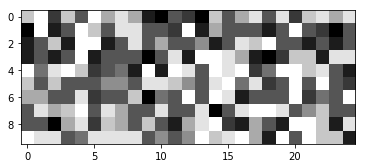

[[7 9 2 7 3 9 6 8 6 1 0 3 2 0 7 3 6 8 3 8 2 7 8 6 8]
 [0 9 1 3 9 7 3 8 8 3 3 2 9 1 6 3 3 3 1 3 9 3 2 0 3]
 [1 3 7 1 9 9 1 3 8 3 6 3 3 5 1 3 8 7 9 3 3 1 3 1 3]
 [1 3 1 3 9 1 3 3 3 0 3 8 1 9 9 8 6 1 0 2 7 7 1 8 8]
 [9 4 8 9 7 2 3 4 1 9 1 9 8 3 9 8 9 2 4 9 9 7 8 3 1]
 [7 3 7 3 3 3 5 5 3 8 8 7 5 3 8 9 4 8 2 3 9 3 9 3 2]
 [6 6 3 3 8 2 3 3 7 0 4 3 9 3 9 8 1 3 3 3 9 2 4 3 9]
 [3 8 6 7 9 3 8 6 3 3 8 3 3 8 0 3 8 9 9 8 3 5 7 3 3]
 [3 3 0 6 8 2 7 6 3 7 3 1 6 8 9 2 1 6 3 1 9 9 7 1 8]
 [9 8 8 3 4 8 8 8 8 3 5 3 5 9 7 8 9 6 1 9 3 9 7 7 1]]


In [3]:
def quantizeFeats(featIm, meanFeats):
    [h, w, d] = np.shape(featIm)
    [k, dk] = np.shape(meanFeats)
    assert (d==dk)
    labelIm = np.arange(h*w).reshape([h,w])
    # Convert to floats instead of the default 8 bits integer coding. Dividing by
    # 255 is important so that plt.imshow behaves works well on float data (need to
    # be in the range [0-1])
    #featIm = np.array(featIm, dtype=np.float64) / 255

    # Load Image and transform to a 2D numpy array.
    h, w, d = original_shape = tuple(featIm.shape)
    image_array = np.reshape(featIm, (w * h, d))
    #image_array_sample = shuffle(image_array, random_state=0)[:1000]
    image_array_sample = meanFeats
    print("Fitting model with the give k x d meanFeats data")
    kmeans = KMeans(n_clusters=k, random_state=0).fit(image_array_sample)
    #print (kmeans.labels_)
    
    # Get labels for all points
    print("Predicting color indices on the full image (k-means)")
    labelIm = kmeans.predict(image_array)
    labelIm = np.reshape(labelIm, (h, w))
    plt.imshow(labelIm)
    plt.show()
    return labelIm

##################################################################################
#featIm = data.astronaut() #h x w x d
h = 10
w = 25
d = 10
featIm = np.random.randint(0, 255, size=(h, w, d), dtype='int')
#print (featIm)
k = 10
meanFeats = np.random.randint(0, 255, size=(k, d), dtype='int') #k = 5 and d of 0 to 255 values
labelIm = quantizeFeats(featIm, meanFeats)

print (labelIm)

1.b [5 pts] Given a cell array imStack of length n containing a series of n grayscale images and a
filter bank bank, compute a texton “codebook” (i.e., set of quantized filter bank responses)
based on a sample of filter responses from all n images. Note that a cell array can index
matrices of different sizes, so each image may have a different width and height. Please
include a function with this form:
function [textons] = createTextons(imStack, bank, k)
where bank is an m x m x d matrix containing d total filters, each of size m x m, and textons
is a k x d matrix in which each row is a texton, i.e., one quantized filter bank response. See
provided code and data below for “filterBank.mat” when applying this function, i.e., to
populate bank with some common filters. Note that to reduce complexity you may randomly
sample a subset of the pixels’ filter responses to be clustered. That is, not every pixel need be
used. 

In [6]:
# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 10. * np.pi
    for sigma in (1, 5):
        for frequency in (0.25, 0.85):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            #print (np.shape(kernel))
            #plt.imshow(kernel)
            #plt.show()
            kernels.append(kernel)
            
def dist2(x, c):
    """Calculates squared distance between two sets of points.
	Description
	D = DIST2(X, C) takes two matrices of vectors and calculates the
	squared Euclidean distance between them.  Both matrices must be of
	the same column dimension.  If X has M rows and N columns, and C has
	L rows and N columns, then the result has M rows and L columns.  The
	I, Jth entry is the  squared distance from the Ith row of X to the
	Jth row of C.
	See also
	GMMACTIV, KMEANS, RBFFWD
	Copyright (c) Ian T Nabney (1996-2001)
        and Neil D. Lawrence (2009) (translation to python)
"""
    
    (ndata, dimx) = x.shape
    (ncentres, dimc) = c.shape
    if not dimx == dimc:
        raise Exception('Data dimension does not match dimension of centres')
        
    n2 = np.tile(np.multiply(x,x).sum(1).reshape(-1, 1), (1, ncentres)) \
        + np.tile(np.multiply(c,c).sum(1).reshape(-1, 1), (1, ndata)).T \
        - 2*np.dot(x,c.T)

    # Rounding errors occasionally cause negative entries in n2
    if np.any(n2<0):
        n2[np.nonzero(n2<0)] = 0
    return n2

Number of Images:  2


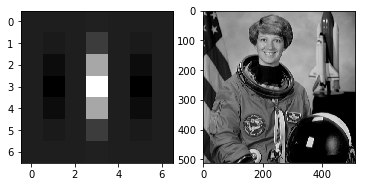

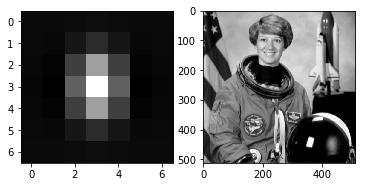

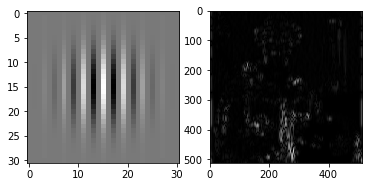

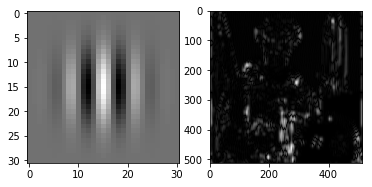

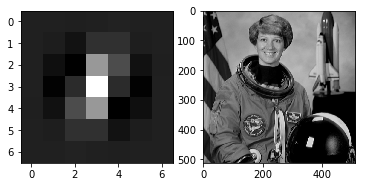

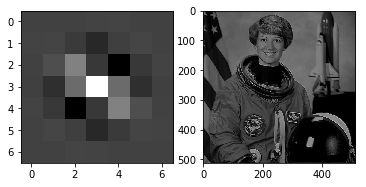

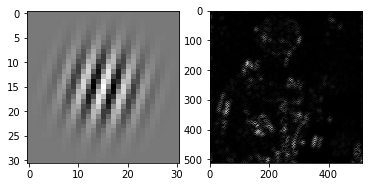

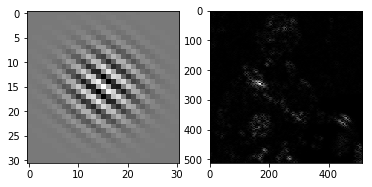

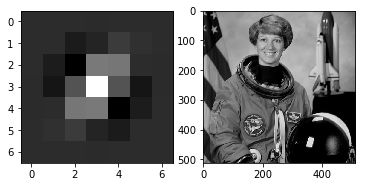

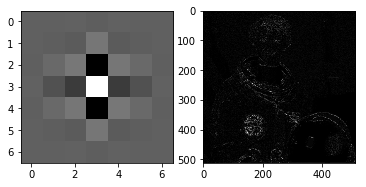

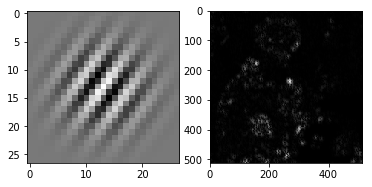

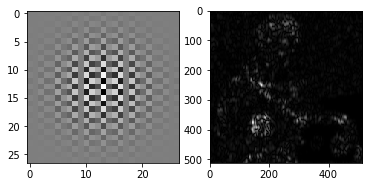

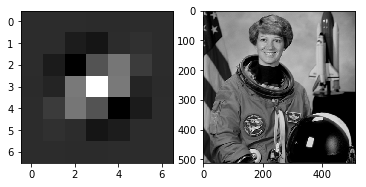

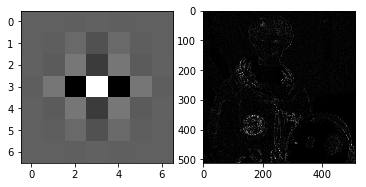

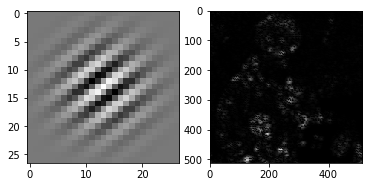

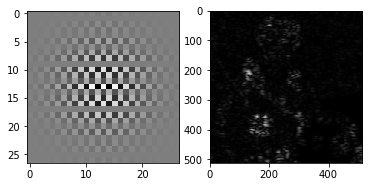

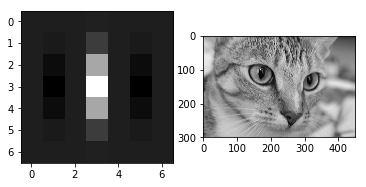

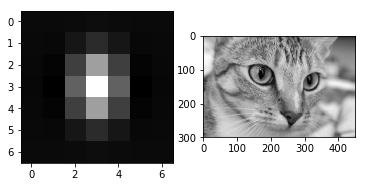

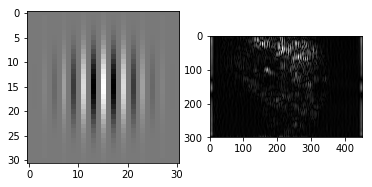

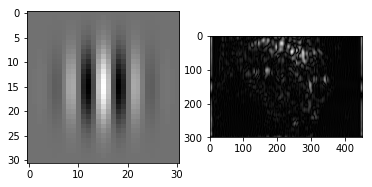

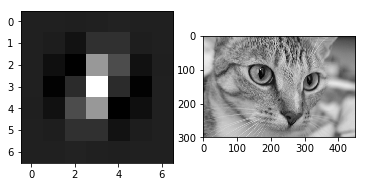

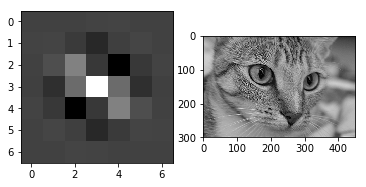

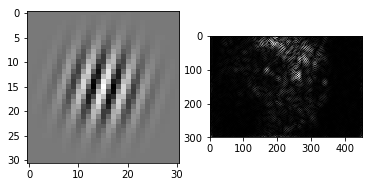

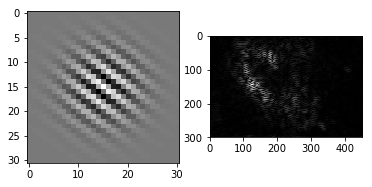

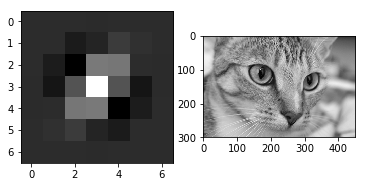

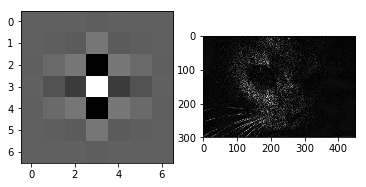

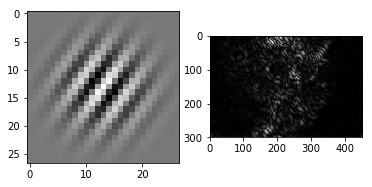

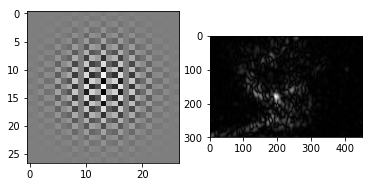

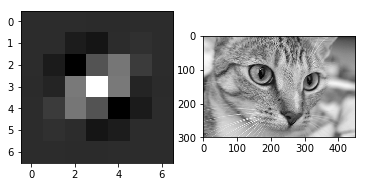

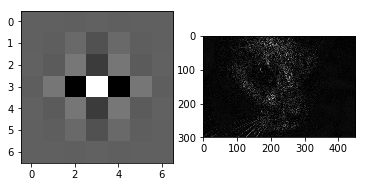

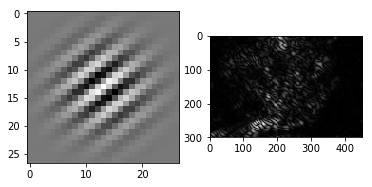

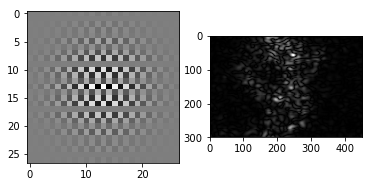

In [7]:
def createTextons(imStack, bank, k=1):
    print ("Number of Images: ", len(imStack))
    #np.sqrt(ndi.convolve(image, np.real(bank), mode='wrap')**2 +
                  # ndi.convolve(image, np.imag(bank), mode='wrap')**2)
    imFilterResponse = []
    textons = []
    plt.figure(1)

    for img in imStack:
        #img_sample = shuffle(img, random_state=0)[:1000]
        #img_sample = np.reshape(100, 100)
        #image = (imStack - imStack.mean()) / imStack.std()
        for kernel in bank:
            imFilterResponse.append(rgb2gray(np.sqrt(ndi.convolve(img, np.real(kernel), mode='wrap')**2 + \
                   ndi.convolve(img, np.imag(kernel), mode='wrap')**2)))
            plt.subplot(121)
            plt.imshow(kernel)
            plt.subplot(122)
            plt.imshow(imFilterResponse[-1])
            plt.show()

        textons.append((imFilterResponse))
    
    return textons
    #imFilterResponse = np.zeros(len(imStack), dtype=filterSize)
    


imStack = (rgb2gray(data.astronaut()), rgb2gray(data.chelsea()))
#viewer = ImageViewer(imStack)
#viewer.show()
textons = createTextons(imStack, kernels, k=1)

1.c [5 pts] Given a grayscale image, filter bank, and texton codebook, construct a texton histogram
for each pixel based on the frequency of each texton within its neighborhood (as defined by a
local window of fixed scale winSize). Note that textons are discrete. A pixel is mapped to one discrete texton based on its distance to each texton. (see quantizeFeats above).
Please include a function with this form:
function [featIm] = extractTextonHists(origIm, bank, textons, winSize)
where textons is a k x d matrix. 

function [featIm] = extractTextonHists(origIm, bank, textons, winSize) 

Number of Images:  1


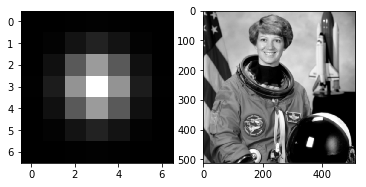

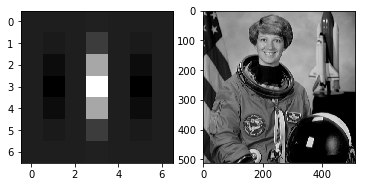

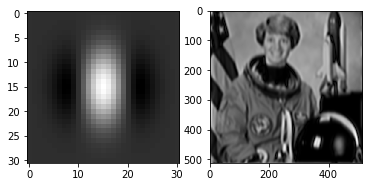

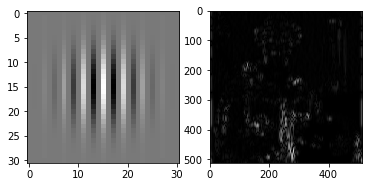

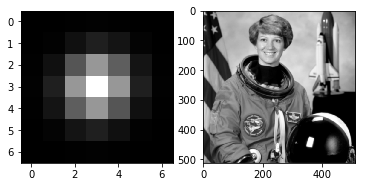

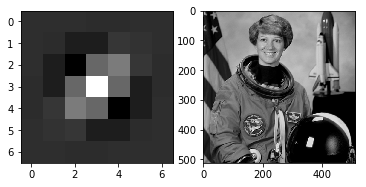

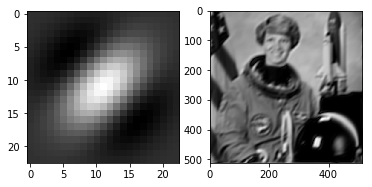

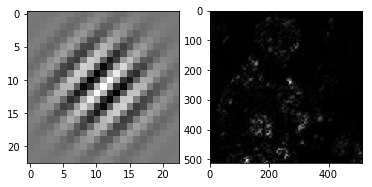

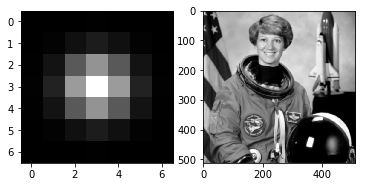

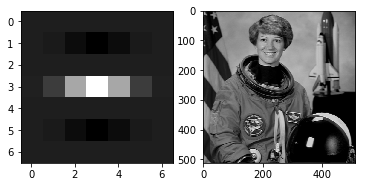

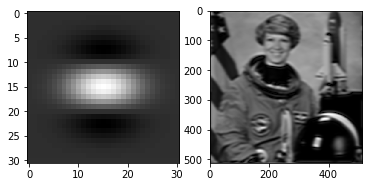

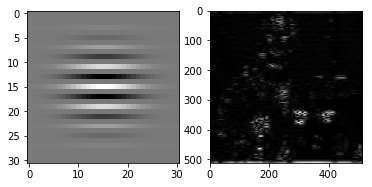

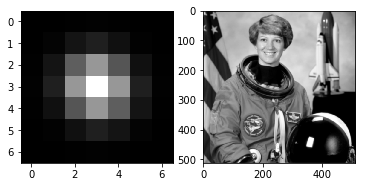

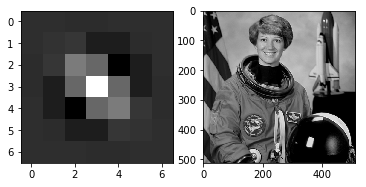

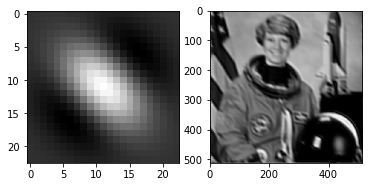

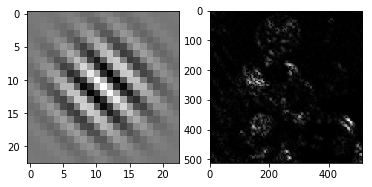

size of textons : (1, 16, 512, 512)


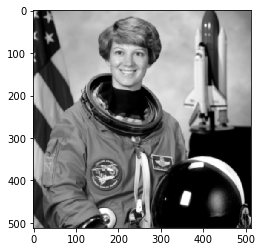

In [232]:
#from numpy import linalg as LA
def extractTextonHists(origIm, bank, textons, winSize=2):
    featIm = 0
    textons= createTextons(origIm, bank)
    #plt.imshow(textons[0][0])
    #plt.show()
    
    min_value = np.inf
    min_i = None
    for i in range(textons.shape[0]):
        D = LA.norm(origIm-textons[i][0]) #Eculidean Distance
        #image_array_sample = shuffle(origIm, random_state=0)[:winSize]
        if D < min_value:
                min_value = D
                min_i = i
    '''
    print (origIm[imageWindow[:]])
    for patch in (grass_patches + sky_patches):
        glcm = greycomatrix(patch, [5], [0], 256, symmetric=True, normed=True)
        xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
        ys.append(greycoprops(glcm, 'correlation')[0, 0])
    return featIm
    kmeans = KMeans(n_clusters=len(textons), random_state=0).fit(textons)
    
    #labelIm = quantizeFeats(featIm, meanFeats)
    '''
    #return featIm

origIm = []                
origIm.append (rgb2gray(data.astronaut()))

extractTextonHists(origIm, kernels, textons, winSize = 5)

1.d [5 pts] Given an h x w x 3 RGB color image origIm, compute two segmentations: one
based on color features and one based on texture features. The color segmentation should be
based on k-means clustering of the colors appearing in the given image. The texture
segmentation should be based on k-means clustering of the image’s texton histograms. Please
include a function:
function [colorLabelIm, textureLabelIm] =
compareSegmentations(origIm, bank, textons, winSize,
numColorRegions, numTextureRegions)
where colorLabelIm and textureLabelIm are h x w matrices recording segment/region
labels, numColorRegions and numTextureRegions specify the number of desired
segments for the two feature types, and the others are defined as above. 

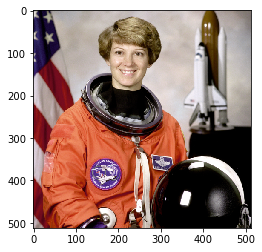

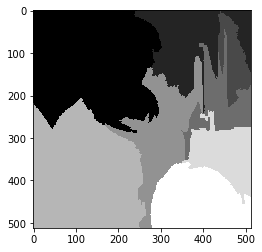

In [38]:
from skimage.segmentation import slic
from skimage.data import astronaut
img = astronaut()
plt.imshow(img)
plt.show()
segments = slic(img, n_segments=15, compactness=10, multichannel=True)
plt.imshow(segments)
plt.show()


1.e [15 pts] Now for the results. Write a script segmentMain.m that calls the above functions
appropriately using the provided images (gumballs.jpg, snake.jpg, and twins.jpg) and
one other image of your choosing, and then displays the results to compare segmentations
with color and texture. Include the following variants:

 Choose parameter values (k, numRegions, winSize, etc) that yield a reasonable
looking segmentations for each feature type and display results for the provided
images. Of course, they won’t perfectly agree with the object boundaries. We’ll
evaluate your assignment for correctness and understanding of the concepts, not the
precise alignment of your regions.

 Consider two window sizes for the texture representation, a smaller and larger one,
with sizes chosen to illustrate some visible and explainable tradeoff on one of the
example images.

 Run the texture segmentation results with two different filter banks. One that uses all
the provided filters, and one that uses a subset of the filters (of your choosing) so as
to illustrate a visible difference in the resulting segmentations that you can explain for
one of the example images. Note that the filter banks are organized by scale,
orientation, and type. You might choose to make the subset you use quite limited to
make the visual difference dramatic.


Fitting model with the give k x d meanFeats data
Predicting color indices on the full image (k-means)


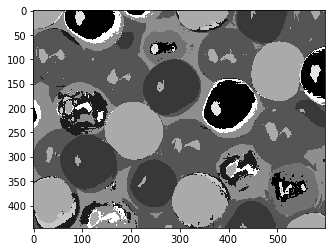

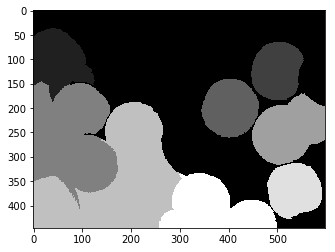

Fitting model with the give k x d meanFeats data
Predicting color indices on the full image (k-means)


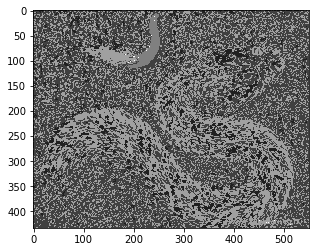

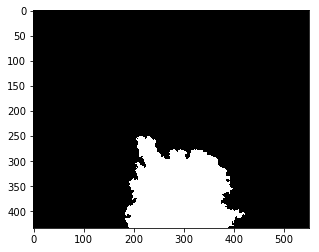

Fitting model with the give k x d meanFeats data
Predicting color indices on the full image (k-means)


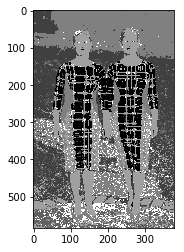

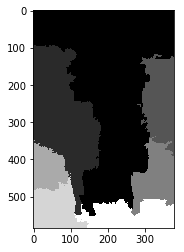

In [56]:
filename = os.path.join(data_dir, 'gumballs.jpg')
imGumBalls = io.imread(filename)

k = 10
d= 3
plt.figure(1)

meanFeats = np.random.randint(0, 255, size=(k, d), dtype='int') #k = 5 and d of 0 to 255 values
#plt.subplot(1,2,1)
labelIm = quantizeFeats(imGumBalls, meanFeats)
#plt.subplot(1,2,2)
segments = slic(imGumBalls, n_segments=15, compactness=10, multichannel=True)
plt.imshow(segments)
plt.show()

filename = os.path.join(data_dir, 'snake.jpg')
imSnake = io.imread(filename)
labelIm = quantizeFeats(imSnake, meanFeats)
segments = slic(imSnake, n_segments=15, compactness=10, multichannel=True)
plt.imshow(segments)
plt.show()

filename = os.path.join(data_dir, 'twins.jpg')
imtwins = io.imread(filename)
labelIm = quantizeFeats(imtwins, meanFeats)
segments = slic(imtwins, n_segments=15, compactness=10, multichannel=True)
plt.imshow(segments)
plt.show()





1.f) [15 pts] In your writeup, explain all the results. Embed figures to illustrate, and label all figures
clearly. We’d like to see one color/texture segmentation for each image. Then for each of the
variations above, just choose one image to do the analysis.
Important: We are expecting only reasonable segmentation results, not perfect results. Part of this
exercise is to experience firsthand the challenge of unsupervised segmentation. We will not deduct
any points from you if (1) your code is correct, and (2) you show effort in selecting a reasonable
parameter setting, and (3) you explain your results clearly. 

### 2. Circle detection with the Hough Transform
[50 points total]
Implement a Hough Transform circle detector that takes an input
image and a fixed (known) radius, and returns the centers of any
detected circles of about that size.
Include a function with the following form:
[centers] = detectCircles(im, radius)
where im is the input image, radius specifies the size of circle
we are looking for. Your detector should not exploit the gradient
direction, though this is an option for extra credit (see below). The
output centers is an N x 2 matrix in which each row lists the
x,y position of a detected circle’s center. Write whatever helper functions are useful. 

In [58]:
def detectCircles(im, radius):
    
    return centers

[20 pts] Demonstrate the function applied to the provided images coins.jpg and
planets.jpg and one image of your choosing. Display the images with detected
circle(s), labeling the figure with the radius. You can use the Matlab function
impixelinfo or imdistline to estimate the radius of interest manually. Note: you only
need to select one reasonable radius and display all detected circles (i.e., those with
highest votes) under that radius. You are not required to consider circles with a center off 
the image. Explain how your implementation post-processes the accumulator array to
determine automatically how many circles are present.

c) [10 pts] For one of the images, display and briefly comment on the Hough space
accumulator array.


d) [10 pts] For one of the images, demonstrate and explain the impact of the vote space
quantization (bin size). In other words, alter the bin size and compare and contrast with a
brief explanation why what happened makes sense.

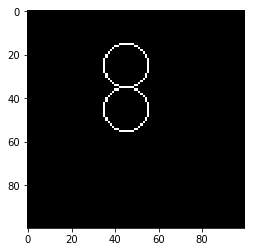

[[[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]]
25 45 5


In [86]:
#Example from Python ski-image library functions
from skimage.transform import hough_circle
from skimage.draw import circle_perimeter
img = np.zeros((100, 100), dtype=np.bool_)
rr, cc = circle_perimeter(25, 45, 10) #
rr1, cc1 = circle_perimeter(45, 45, 10) #

img[rr, cc] = 1
img[rr1, cc1] = 1

plt.imshow(img)
plt.show()
try_radii = np.arange(5, 50)
res = hough_circle(img, 10)
print (res)
ridx, r, c = np.unravel_index(np.argmax(res), res.shape)
print (r, c, try_radii[ridx])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

filename = os.path.join(data_dir, 'coins.jpg')
filename = os.path.join(data_dir, 'planets.jpg')

image = (((io.imread(filename))))
image_gray = (img_as_ubyte(rgb2gray(io.imread(filename))))
# Load picture and detect edges
#image = img_as_ubyte(data.coins()[160:230, 70:270])
edges = canny(image_gray, sigma=2, low_threshold=5, high_threshold=50)

plt.imshow(edges)
plt.show()
# Detect two radii
hough_radii = np.arange(10, 250, 10)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 5 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=20)

print (" Center and Radii detected at :\n", cx, cy, radii)
# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = color.gray2rgb(image)
print (image.shape)
print (np.shape(image))
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius)
    image[circy, circx] = (250, 20, 20)


ax.imshow(image, cmap=plt.cm.gray)
plt.show()
viewer = ImageViewer(image)
viewer.show()